# **Skin Cancer Detection Project**

# **Introduction**

## **The Challenge**

**Problem Description & Purpose:**
Skin cancer is the most common form of cancer worldwide, with melanoma being its deadliest subtype. Although melanoma accounts for only a small fraction of skin cancer cases, it is responsible for nearly 75% of skin cancer–related deaths. In 2020 alone, the American Cancer Society estimated more than 100,000 new melanoma cases and nearly 7,000 related deaths in the United States. As with most cancers, early and accurate detection is critical, as timely intervention can significantly improve treatment outcomes.

Traditionally, dermatologists rely on close visual inspection of all skin lesions, focusing on "outlier" moles—often referred to as the "ugly duckling" sign—that deviate from the patient,s other lesions. While this approach has proven valuable, it remains subjective and prone to human error. Advances in artificial intelligence (AI) and computer vision offer the potential to support dermatologists by automating lesion analysis and highlighting suspicious cases. However, many existing AI methods overlook the patient-level context that clinicians naturally incorporate when comparing lesions.

From a machine learning perspective, this is formulated as a binary classification problem. The dataset contains dermoscopic images of skin lesions labeled as either `benign` or `malignant`, along with patient-level metadata such as `sex`, `age`, and `anatomical site`. The goal is to train a model that can automatically classify each lesion image into its correct category (`benign = 0`, `malignant = 1`).

**Solution Impact:**
The proposed solution has the potential to significantly improve the early detection and diagnosis of melanoma. By integrating dermoscopic images with patient-level metadata, the model is designed to more closely mirror the way dermatologists assess lesions in practice, thereby improving classification accuracy and clinical relevance. Earlier and more reliable detection can increase the chances of successful treatment while reducing unnecessary biopsies, ultimately lowering healthcare costs and minimizing patient discomfort. Beyond clinical support, such a system could be transformative in terms of accessibility: with only an internet connection, individuals in remote areas, underserved regions, or developing countries could benefit from AI-assisted screening, even in the absence of readily available dermatologists. Similarly, in developed countries where long wait times to see a specialist can delay diagnosis, an automated tool could provide earlier risk assessment, ensuring timely intervention. Ultimately, this solution demonstrates how AI-driven healthcare can extend life-saving diagnostic capabilities to millions of people worldwide, bridging the gap between medical expertise and patient needs.

<div style="display: flex; gap: 20px; align-items: flex-start;">
  <!-- First image -->
  <div style="text-align:center;">
    <img src="https://s.yimg.com/ny/api/res/1.2/OhIJJV2AtD4tteZoozpBAw--/YXBwaWQ9aGlnaGxhbmRlcjt3PTk2MDtoPTU2MTtjZj13ZWJw/https://media.zenfs.com/en/globenewswire.com/2b76a1c54c75e7988e50b7b01188d5ae" width="400">
    <p>Source: <a href="https://finance.yahoo.com/news/global-melanoma-therapeutics-market-size-070000275.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAKGtg65y-SiIlI9i2VF4ZCVswcBexuQdi_DBokDkpFzQWCGPKceKrLUofdstPpB7QbxyAO7vTtwwUCsgnBUuJ3R9vqz2BbM5gAzmJRltby1EjLuB6l9Iw8JgJ4sO-d80hBDhw2tVRkrv_yX-_uDEsA68VD9t_vA6AE9q9Jh7RrCL"><b>Yahoo Finance</b></a></p>
  </div>

  <!-- Second image -->
  <div style="text-align:center;">
    <img src="https://cdn.statcdn.com/Infographic/images/normal/32207.jpeg" width="400">
    <p>Source: <a href="https://www.statista.com/chart/32207/new-cases-and-deaths-from-melanoma-of-the-skin/"><b>Statista</b></a></p>
  </div>
</div>


## **Data Collection**

The dataset for this project comes from the **SIIM-ISIC Melanoma Classification Challenge** on Kaggle (https://www.kaggle.com/competitions/siim-isic-melanoma-classification/overview), organized by the **Society for Imaging Informatics in Medicine (SIIM)** and the **International Skin Imaging Collaboration (ISIC)**. It represents the largest publicly available collection of quality-controlled dermoscopic images of skin lesions, created to support research in automated melanoma detection.

The dataset includes 33,126 training images and 10,982 test images in both JPEG and DICOM formats, each paired with structured patient-level metadata. The training metadata contains the following fields:

* **image_name** - unique identifier linking to the corresponding image file
* **patient_id** - unique identifier for each patient (allowing grouping of multiple lesions per patient)
* **sex** - patient sex (blank if unknown)
* **age_approx** - approximate patient age at the time of imaging
* **anatom_site_general_challenge** - anatomical site of the lesion (e.g., torso, lower extremity)
* **diagnosis** - detailed diagnostic label (present only in the training set)
* **benign_malignant** - categorical indicator of lesion type (benign or malignant)
* **target** - binarized training label (0 = benign, 1 = malignant)

The test metadata contains **only the first five features** (`image_name`, `patient_id`, `sex`, `age_approx`, `anatom_site_general_challenge`) and does not include `diagnosis`, `benign_malignant`, or `target`.

Ground-truth labels are established through rigorous validation: `malignant` cases are confirmed by histopathology, while `benign` cases are verified by expert consensus or clinical follow-up.

This combination of dermoscopic images and clinical metadata makes the dataset especially well-suited for developing multi-modal deep learning models that integrate both visual and contextual patient information to improve melanoma detection.

# **Data Preprocessing**

Before performing data understanding and analysis in the EDA process, we must first prepare the data for processing, while also ensuring that no information from the test set is accidentally leaked into the training set. We begin by loading the tabular data into Pandas DataFrames and defining the paths for the training and test sets:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy
import pandas

unknown = "unknown"

project_path = "/content/drive/MyDrive/SkinCancerDetectionProject"
data_path = os.path.join(project_path, "data")

train_images_path = os.path.join(data_path, "train")
test_images_path = os.path.join(data_path, "test")

train_df = pandas.read_csv(os.path.join(project_path, "train.csv"))
# test_df = pandas.read_csv(os.path.join(project_path, "test.csv"))

**Split into Train/Validation/Test**

We reserve **15%** of the data as a **validation set** for hyperparameter tuning and model evaluation, and another **15%** as a separate **test set** for final performance assessment. The `stratify` parameter is used during splitting to ensure that both classes remain balanced across all sets:

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    train_df,
    test_size=0.3,
    stratify=train_df["target"],
    random_state=42,
    shuffle=True
)

test_df, val_df = train_test_split(
    test_df,
    test_size=0.5,
    stratify=test_df["target"],
    random_state=42,
    shuffle=True
)

We'll now append the associated image filepath to each sample in the dataset:

In [ ]:
def get_id_to_path_map(paths, image_names):
  from tqdm.auto import tqdm
  image_names_set = set(image_names)
  id_to_path = {}
  for f in tqdm(os.listdir(paths), desc="Processing"):
      stem, ext = os.path.splitext(f)
      key = stem.lower().strip()
      if key in image_names_set:
          id_to_path[key] = os.path.join(paths, f)
  return id_to_path

def get_id_to_path_map_subfolders(path, image_names):
  final_map = dict()
  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
      id_to_path = final_map.update(get_id_to_path_map(folder_path, image_names))
  return final_map

for df in [train_df, val_df, test_df]:
    df["image_name_reduced"] = df["image_name"].str.replace(r"\.[^.]+$", "", regex=True).str.strip().str.lower()

id_to_train_path = get_id_to_path_map_subfolders(train_images_path, train_df["image_name_reduced"])
id_to_val_path = get_id_to_path_map_subfolders(train_images_path, val_df["image_name_reduced"])
id_to_test_path = get_id_to_path_map_subfolders(train_images_path, test_df["image_name_reduced"])

train_df["image_path"] = train_df["image_name_reduced"].map(id_to_train_path)
val_df["image_path"] = val_df["image_name_reduced"].map(id_to_val_path)
test_df["image_path"] = test_df["image_name_reduced"].map(id_to_test_path)

for df in [train_df, val_df, test_df]:
  df.drop("image_name_reduced", axis=1, inplace=True)

Processing:   0%|          | 0/4686 [00:00<?, ?it/s]

Processing:   0%|          | 0/5004 [00:00<?, ?it/s]

Processing:   0%|          | 0/6120 [00:00<?, ?it/s]

Processing:   0%|          | 0/6204 [00:00<?, ?it/s]

Processing:   0%|          | 0/6336 [00:00<?, ?it/s]

Processing:   0%|          | 0/4776 [00:00<?, ?it/s]

Processing:   0%|          | 0/4686 [00:00<?, ?it/s]

Processing:   0%|          | 0/5004 [00:00<?, ?it/s]

Processing:   0%|          | 0/6120 [00:00<?, ?it/s]

Processing:   0%|          | 0/6204 [00:00<?, ?it/s]

Processing:   0%|          | 0/6336 [00:00<?, ?it/s]

Processing:   0%|          | 0/4776 [00:00<?, ?it/s]

Processing:   0%|          | 0/4686 [00:00<?, ?it/s]

Processing:   0%|          | 0/5004 [00:00<?, ?it/s]

Processing:   0%|          | 0/6120 [00:00<?, ?it/s]

Processing:   0%|          | 0/6204 [00:00<?, ?it/s]

Processing:   0%|          | 0/6336 [00:00<?, ?it/s]

Processing:   0%|          | 0/4776 [00:00<?, ?it/s]

**Handle Missing Values**

An important step in preprocessing is identifying and addressing missing values in the dataset. Certain features in the training set contain incomplete data, which must be handled carefully to avoid bias and ensure the model can learn effectively. The following columns were found to have missing values:

In [ ]:
base_message = "{0} Set - Missing Values:\n"
breaker = "\n" + ("-" * 40)

missing_counts = train_df.isna().sum()
print(base_message.format("Training"), missing_counts[missing_counts > 0], breaker)

missing_counts = val_df.isna().sum()
print(base_message.format("Validation"), missing_counts[missing_counts > 0], breaker)

missing_counts = test_df.isna().sum()
print(base_message.format("Test"), missing_counts[missing_counts > 0], breaker)

Training Set - Missing Values:
 sex                               46
age_approx                        48
anatom_site_general_challenge    369
dtype: int64 
----------------------------------------
Validation Set - Missing Values:
 sex                               9
age_approx                        9
anatom_site_general_challenge    78
dtype: int64 
----------------------------------------
Test Set - Missing Values:
 sex                              10
age_approx                       11
anatom_site_general_challenge    80
dtype: int64 
----------------------------------------


As we can see, there are no missing images - each metadata row has a corresponding image associated with it:

In [ ]:
for name, df in [("train_df", train_df), ("val_df", val_df), ("test_df", test_df)]:
    missing = df["image_path"].isna().sum()
    total = len(df)
    print(f"{name}: {missing} missing image paths out of {total} rows")

train_df: 0 missing image paths out of 23188 rows
val_df: 0 missing image paths out of 4969 rows
test_df: 0 missing image paths out of 4969 rows


We address missing values using different strategies tailored to each feature. For the `sex` column, we replace missing values with an `"unknown"` category, ensuring that all patients remain in the dataset **without introducing bias or distorting the class distribution** by arbitrarily assigning `"male"` or `"female"`.

For the `age_approx` column, we impute missing entries with the **median age**, a robust measure that preserves the overall distribution while minimizing the influence of outliers.

Finally, for the `anatom_site_general_challenge` column, we apply a **conditional sampling strategy:** each missing entry is filled based on the observed probability distribution of anatomical sites given the patient’s age. This approach maintains consistency with clinical patterns observed in the dataset and avoids discarding valuable samples.

In [ ]:
def sample_conditional_variable(df, conditioned_variable, conditioning_variable):
  prob_table = df.groupby(conditioning_variable)[conditioned_variable].value_counts(normalize=True)

  def sample(row):
      if pandas.isna(row[conditioned_variable]):
          val = row[conditioning_variable]
          if val in prob_table.index.levels[0]:
              choices = prob_table[val].index.tolist()
              probs = prob_table[val].values
              return numpy.random.choice(choices, p=probs)
          else:
              return unknown
      else:
          return row[conditioned_variable]
  return sample

def fill_anatom_site_value():
  train_age_median = train_df["age_approx"].median()
  train_df["age_approx"] = train_df["age_approx"].fillna(train_age_median)
  train_df["age_bin"] = pandas.cut(train_df["age_approx"], bins=list(range(0, 101, 10)), include_lowest=True)

  sample_row_func = sample_conditional_variable(train_df, "anatom_site_general_challenge", "age_bin")

  def fill_value(row):
    return sample_row_func(row)

  return fill_value

def handle_missing_values(df, age_median):
    df = df.copy()
    df["age_approx"] = df["age_approx"].fillna(age_median)
    df["age_bin"] = pandas.cut(df["age_approx"], bins=list(range(0, 101, 10)), include_lowest=True)
    df["sex"] = df["sex"].fillna(unknown)
    df["anatom_site_general_challenge"] = df.apply(fill_anatom_site_value(), axis=1)
    return df

In [ ]:
train_age_median = train_df["age_approx"].median()

train_df = handle_missing_values(train_df, train_age_median)
val_df = handle_missing_values(val_df, train_age_median)
test_df = handle_missing_values(test_df, train_age_median)

train_df.drop("age_bin", axis=1, inplace=True)
val_df.drop("age_bin", axis=1, inplace=True)
test_df.drop("age_bin", axis=1, inplace=True)

# Save the cleaned unencoded sets for EDA
unencoded_train_df = train_df.copy()
unencoded_val_df = val_df.copy()
unencoded_test_df = test_df.copy()

/tmp/ipython-input-3910285357.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_table = df.groupby(conditioning_variable)[conditioned_variable].value_counts(normalize=True)
/tmp/ipython-input-3910285357.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_table = df.groupby(conditioning_variable)[conditioned_variable].value_counts(normalize=True)
/tmp/ipython-input-3910285357.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

Because the validation and test sets represent **unseen data**, we should not impute their missing values using information from within those sets. Instead, any missing values in the validation and test sets <u>must be filled using statistics (e.g., mean, median, mode) that are computed from the training set, or using features combination of the sample that its missing value is filled.</u> In our case, we computed the conditional distribution of `anatom_site_general_challenge | age_approx` based on the training set. We then used this distribution to impute missing values of the `anatom_site_general_challenge` feature in the validation and test sets, conditioning on the `age_approx` value of each sample.

**Encode Labels**

We use **one-hot encoding** to represent discrete variables that should not carry an ordinal relationship or are non-numeric. In general, we prefer one-hot encoding over label encoding, since label encoding introduces artificial ordinal relationships that are not meaningful. Here, we apply one-hot encoding to the two categorical features, `anatom_site_general_challenge` and `sex`, which we include in the training process:

In [ ]:
def encode_labels(df, columns):
  return pandas.get_dummies(df, columns=columns, dummy_na=False)

In [ ]:
train_df = encode_labels(train_df, columns=["sex", "anatom_site_general_challenge"])
val_df = encode_labels(val_df, columns=["sex", "anatom_site_general_challenge"])
test_df = encode_labels(test_df, columns=["sex", "anatom_site_general_challenge"])

In [ ]:
train_df.head()

image_name  patient_id  age_approx diagnosis benign_malignant  \
22518  ISIC_6828587  IP_7403252        45.0     nevus           benign   
21622  ISIC_6555618  IP_6538458        50.0   unknown           benign   
14386  ISIC_4407024  IP_4050705        40.0   unknown           benign   
17458  ISIC_5329118  IP_4277352        40.0     nevus           benign   
2287   ISIC_0779135  IP_4938349        70.0   unknown           benign   

       target                                         image_path  sex_female  \
22518       0  /content/drive/MyDrive/SkinCancerDetectionProj...       False   
21622       0  /content/drive/MyDrive/SkinCancerDetectionProj...        True   
14386       0  /content/drive/MyDrive/SkinCancerDetectionProj...        True   
17458       0  /content/drive/MyDrive/SkinCancerDetectionProj...        True   
2287        0  /content/drive/MyDrive/SkinCancerDetectionProj...       False   

       sex_male  sex_unknown  anatom_site_general_challenge_head/neck  \
22518      True        False                                    False   
21622     False        False                                     True   
14386     False        False                                    False   
17458     False        False                                    False   
2287       True        False                                     True   

       anatom_site_general_challenge_lower extremity  \
22518                                           True   
21622                                          False   
14386                                           True   
17458                                          False   
2287                                           False   

       anatom_site_general_challenge_oral/genital  \
22518                                       False   
21622                                       False   
14386                                       False   
17458                                       False   
2287                                        False   

       anatom_site_general_challenge_palms/soles  \
22518                                      False   
21622                                      False   
14386                                      False   
17458                                      False   
2287                                       False   

       anatom_site_general_challenge_torso  \
22518                                False   
21622                                False   
14386                                False   
17458                                 True   
2287                                 False   

       anatom_site_general_challenge_upper extremity  
22518                                          False  
21622                                          False  
14386                                          False  
17458                                          False  
2287                                           False

In [ ]:
train_df.columns

Index(['image_name', 'patient_id', 'age_approx', 'diagnosis',
       'benign_malignant', 'target', 'image_path', 'sex_female', 'sex_male',
       'sex_unknown', 'anatom_site_general_challenge_head/neck',
       'anatom_site_general_challenge_lower extremity',
       'anatom_site_general_challenge_oral/genital',
       'anatom_site_general_challenge_palms/soles',
       'anatom_site_general_challenge_torso',
       'anatom_site_general_challenge_upper extremity'],
      dtype='object')

Notice that we do not apply one-hot encoding to the `diagnosis` feature, since it is **not included in the training process**. We exclude it because **the test set lacks this feature**, meaning that a model trained with `diagnosis` would not be able to evaluate test samples consistently. The preferred way to handle the complete absence of a feature is by defining an auxiliary task, but we avoid this approach due to its added complexity. For now, we remove `diagnosis` from the training and validation sets:

In [ ]:
train_df = train_df.drop("diagnosis", axis=1)
val_df = val_df.drop("diagnosis", axis=1)
test_df = test_df.drop("diagnosis", axis=1)

**Image Preprocessing and Dataset Creation**

Before feeding images into the model, they must be transformed into a format that is compatible with the `EfficientNet` architecture. This involves standardizing the input size, normalizing pixel values, and preparing batches that can be efficiently streamed to the GPU during training. Here we create the `Dataset` objects that will later be used to train and evaluate the model:

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

class ReferenceVariable:
  IMG_SIZE = (380, 380)
  BATCH_SIZE = 64

def path_to_image_id(path):
  filename = tf.strings.split(path, '/')[-1]
  image_id = tf.strings.regex_replace(filename, r"\.(jpg|jpeg|png)$", "")
  return image_id

def decode_and_preprocess(path):
  path = tf.cast(path, tf.string)
  bytestr = tf.io.read_file(path)
  img = tf.image.decode_image(bytestr, channels=3, expand_animations=False)
  img = tf.image.resize(img, ReferenceVariable.IMG_SIZE)
  img = tf.cast(img, tf.float32)
  img = preprocess_input(img)
  return img

def convert_vector_to_element(features, target):
  image = decode_and_preprocess(features["image_path"])

  exclude = {"image_path", "image_name", "patient_id", "benign_malignant", "target"}
  keys = [k for k in features.keys() if k not in exclude]

  # preserve a consistent order of features
  keys = sorted(keys)

  feat_list = [tf.cast(features[k], tf.float32) for k in keys]
  feat_vec = tf.stack(feat_list, axis=-1)

  target = tf.cast(target, tf.int32) if target is not None else target
  return (image, feat_vec), target

def build_dataset(df, shuffle=False):
  has_target = "target" in df.columns

  if has_target:
      # Dataset yields (features, target)
      dataset = tf.data.Dataset.from_tensor_slices((dict(df), df["target"].values))
      map_fn = convert_vector_to_element
  else:
      # Dataset yields just features
      dataset = tf.data.Dataset.from_tensor_slices(dict(df))

      def map_fn(features):
          # Return None for target
          return convert_vector_to_element(features, target=None)

  if shuffle:
      dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)

  dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(ReferenceVariable.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset

Finally, we construct the datasets. Each image is resized and preprocessed to meet the input requirements of the `EfficientNet` model, while also keeping them suitable for visualization:

In [ ]:
full_df = pandas.concat([unencoded_train_df, unencoded_val_df, unencoded_test_df], axis=0, ignore_index=True)
encoded_full_df = pandas.concat([train_df, val_df, test_df], axis=0, ignore_index=True)

In [ ]:
train_dataset = build_dataset(train_df)
val_dataset = build_dataset(val_df)
test_dataset = build_dataset(test_df)

train_benign_dataset = build_dataset(train_df[train_df["target"] == 0])
train_malignant_dataset = build_dataset(train_df[train_df["target"] == 1])

full_dataset = build_dataset(encoded_full_df)
full_benign_dataset = build_dataset(encoded_full_df[encoded_full_df["target"] == 0])
full_malignant_dataset = build_dataset(encoded_full_df[encoded_full_df["target"] == 1])

# **EDA (Exploratory Data Analysis)**

This chapter presents an exploratory analysis of the training dataset. Several methods are employed to uncover and visualize relationships among the features, including conditional probability between variable pairs, dimensionality reduction techniques, clustering algorithms, and more. Since each sample in the training set consists of two distinct feature types - a vector and an image, we first apply different analytical approaches to each type separately, allowing for more tailored and meaningful insights.

## **Visualizing Distributions**

Visualizing the data is a crucial step in understanding it. Each sample in the training set consists of an **image** and a corresponding **metadata vector**. Therefore, it is natural to first visualize the images and the tabular data separately, and then proceed with more advanced visualizations.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

**Visualizing Feature Distributions**

We begin by examining the target variable, which indicates whether a lesion is benign (`0`) or malignant (`1`), to confirm whether the dataset is balanced or imbalanced:

/tmp/ipython-input-945481236.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=full_df, x="target", palette=["royalblue", "red"])


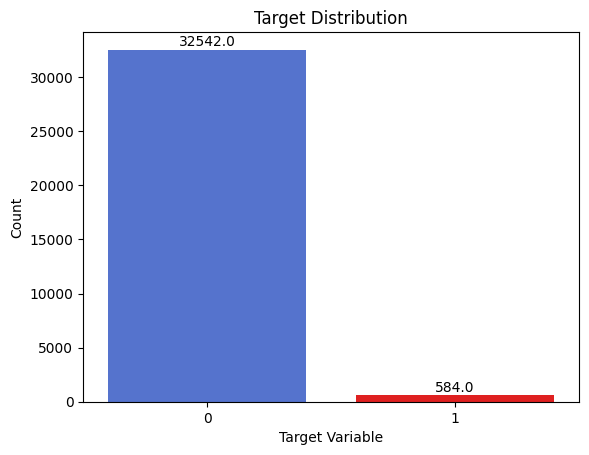

In [ ]:
ax = sns.countplot(data=full_df, x="target", palette=["royalblue", "red"])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height + 80), ha='center', va='bottom')

plt.title("Target Distribution")
plt.xlabel("Target Variable")
plt.ylabel("Count")
plt.show(block=False)

As we see, the dataset exhibits a significant class imbalance - negative (`0`) samples are **much more common** than positive (`1`) samples. Such imbalance can lead to poor model performance, as the model may simply learn to predict the majority class. <u>We assume this imbalance reflects sampling rather than the true distribution of the target variable.</u> Therefore, we will later apply **class weighting**, overweighting the positive samples and underweighting the negative ones, which is a crucial step to ensure balanced learning.

Next, we look at the distribution of **patient ages** and compare it across target classes. Melanoma is often associated with older patients, so it is important to see whether `malignant` cases are more concentrated in certain age groups:

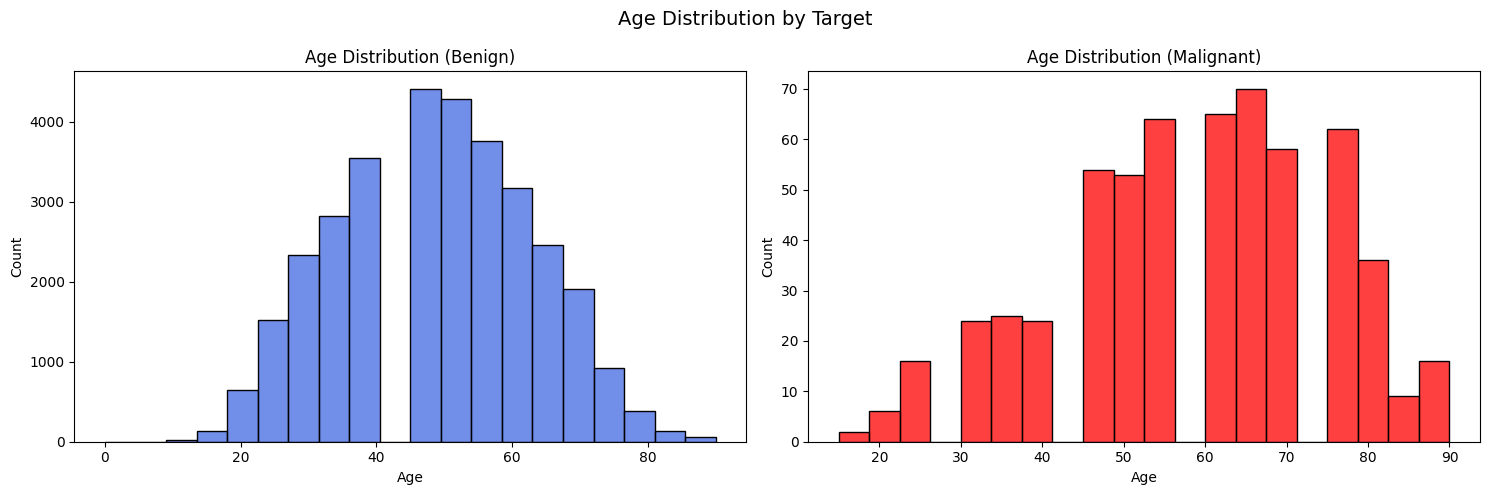

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(
    data=full_df[full_df["target"] == 0],
    x="age_approx",
    bins=20,
    color="royalblue",
    ax=axes[0]
)
axes[0].set_title("Age Distribution (Benign)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

sns.histplot(
    data=full_df[full_df["target"] == 1],
    x="age_approx",
    bins=20,
    color="red",
    ax=axes[1]
)
axes[1].set_title("Age Distribution (Malignant)")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

plt.suptitle("Age Distribution by Target", fontsize=14)
plt.tight_layout()
plt.show(block=False)

It seems that the ages of `malignant` cases are concentrated mostly in the 50-70 range, whereas `benign` cases are more concentrated around 40-60. This suggests a **potential correlation between** `age` **and the target variable**. Since `benign` cases make up the majority of the dataset, the overall `age` distribution is naturally dominated by the age profile of the `benign` samples - as we can see here:

Text(0.5, 0, 'Age')

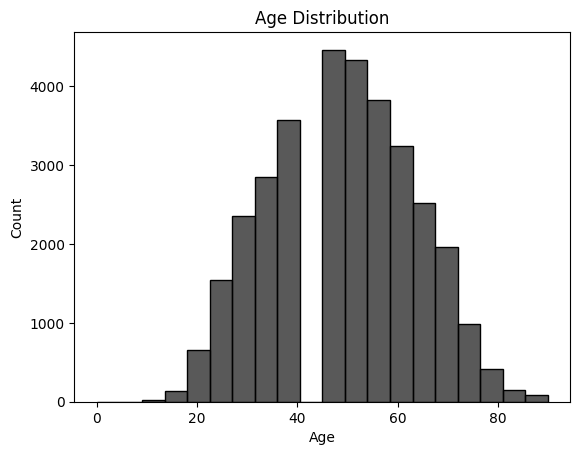

In [ ]:
sns.histplot(data=full_df, x="age_approx", bins=20, color="#222222")
plt.title("Age Distribution")
plt.xlabel("Age")

We then explore the distribution of `sex` in the dataset to identify any imbalance between male and female patients. This also allows us to observe whether the likelihood of malignancy differs between the two groups, which can highlight possible biological or dataset-specific patterns.

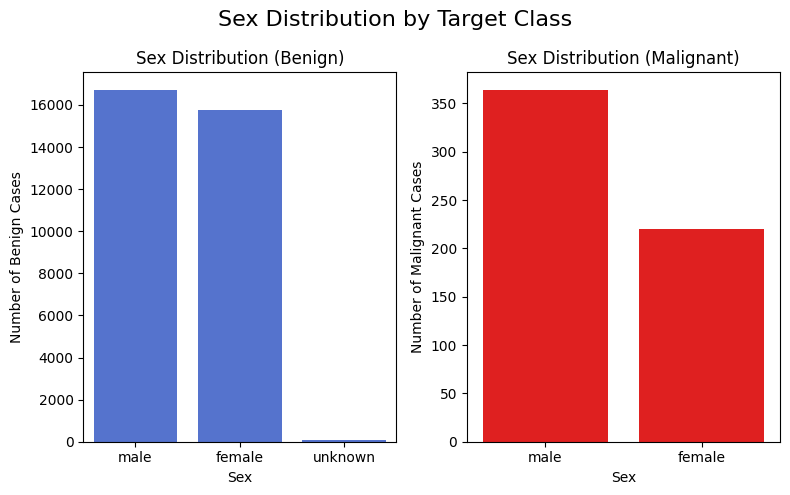

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

sns.countplot(
    data=full_df[full_df["target"] == 0],
    x="sex",
    color="royalblue",
    ax=axes[0]
)
axes[0].set_title("Sex Distribution (Benign)")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Number of Benign Cases")

sns.countplot(
    data=full_df[full_df["target"] == 1],
    x="sex",
    color="red",
    ax=axes[1]
)
axes[1].set_title("Sex Distribution (Malignant)")
axes[1].set_xlabel("Sex")
axes[1].set_ylabel("Number of Malignant Cases")

fig.suptitle("Sex Distribution by Target Class", fontsize=16)

plt.tight_layout()
plt.show(block=False)

Even though the number of `benign` samples is nearly the same for men and women, this balance does not hold for `malignant` cases. <u>Men make up a much larger share of the</u> `malignant` <u>population compared to women.</u> We now examine the overall `sex` distribution to check whether this difference may be explained by a sampling bias:

/tmp/ipython-input-2935169016.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=full_df, x="sex", palette={"male": "royalblue", "female": "red", "unknown": "#222222"}, legend=True)


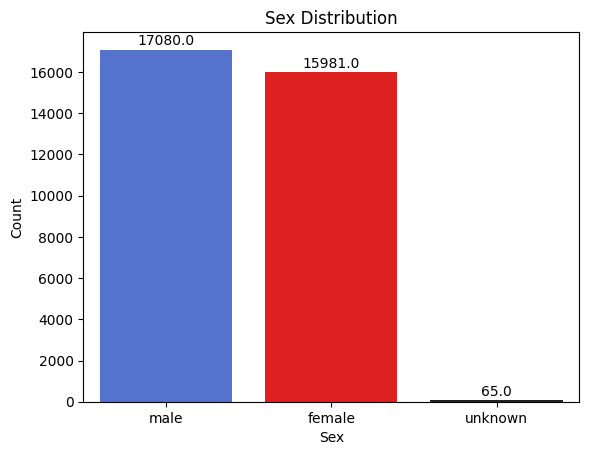

In [ ]:
ax = sns.countplot(data=full_df, x="sex", palette={"male": "royalblue", "female": "red", "unknown": "#222222"}, legend=True)

ax.set_title("Sex Distribution")
ax.set_xlabel("Sex")
ax.set_ylabel("Count")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}",
                (p.get_x() + p.get_width() / 2., height + 80),
                ha="center", va="bottom")

plt.show(block=False)

Finally, we can rest assured that both genders are **represented almost equally** in the training population, which confirms that the overrepresentation of men in the `malignant` group is **not the result of a sampling bias.** Consequently, we conclude that there is a <u>strong correlation between being male and being diagnosed as</u> `malignant`. We now investigate this further by assessing the `malignant` cases count distribution of men by age:

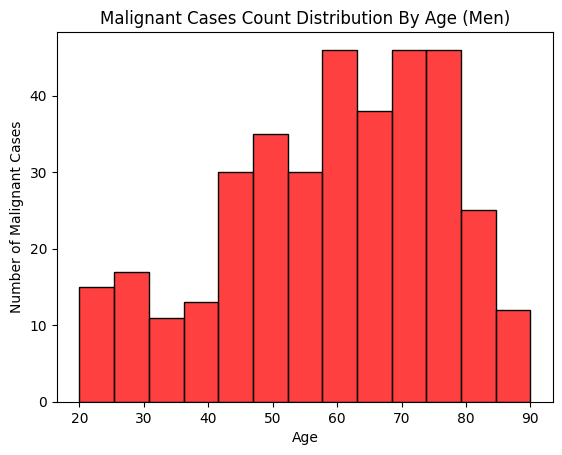

In [ ]:
malignant_men_samples = full_df[(full_df["target"] == 1) & (full_df["sex"] == "male")]
ax = sns.histplot(data=malignant_men_samples, x="age_approx", color="red")

ax.set_xlabel("Age")
ax.set_ylabel("Number of Malignant Cases")
ax.set_title("Malignant Cases Count Distribution By Age (Men)")

plt.show(block=False)

It is clear from the histogram above that men in the age range of roughly 50-80 are **strongly represented** among `malignant` cases compared to those in the 20-45 range. To make this more explicit, we now count the number of `malignant` male samples within consecutive 20-year intervals of `age`:

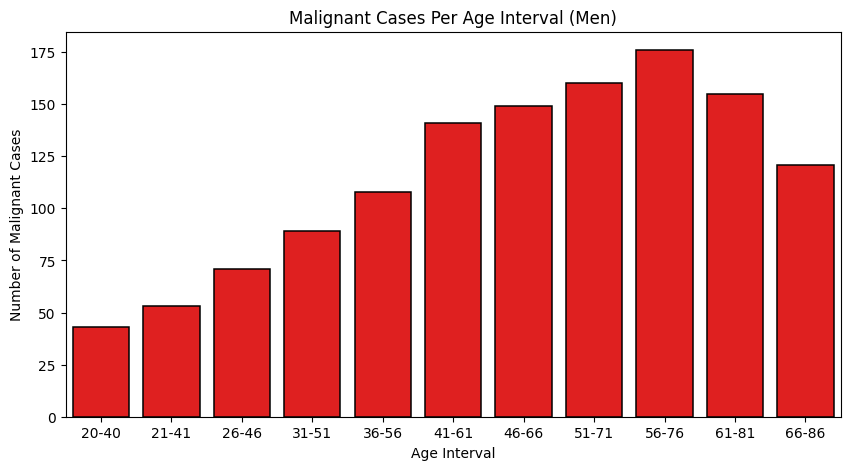

In [ ]:
def get_interval_counts(df, column, interval_length):
  rows = []
  last_interval_count = -1

  min_val, max_val = df[column].min(), df[column].max()

  for interval_start in range(int(min_val), int(max_val - interval_length) + 1):
    interval_end = interval_start + interval_length
    interval_count = ((df[column] >= interval_start) & (df[column] < interval_end)).sum()

    if interval_count != last_interval_count:
      rows.append({"start": interval_start, "end": interval_end, "count": interval_count, "label": f"{interval_start}-{interval_end}"})
      last_interval_count = interval_count

  new_df = pandas.DataFrame(rows)
  return new_df

age_interval_count_df = get_interval_counts(malignant_men_samples, "age_approx", 20)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=age_interval_count_df, x="label", y="count", color="red", edgecolor="black", linewidth=1.1)

ax.set_xlabel("Age Interval")
ax.set_ylabel("Number of Malignant Cases")
ax.set_title("Malignant Cases Per Age Interval (Men)")

plt.show(block=False)

Certain age intervals in the histogram contain **two to three times** more `malignant` male samples than others, suggesting a strong **relationship between older men and `malignant` cases.** Next, we examine whether a similar pattern holds for women as well:

/tmp/ipython-input-403739070.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = malignant.pivot_table(


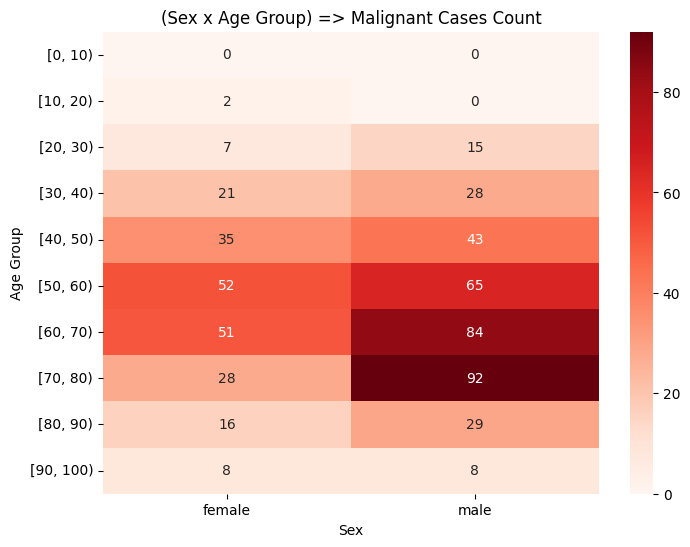

In [ ]:
malignant = full_df[full_df["target"] == 1].copy()

bins = range(0, 101, 10)
malignant["age_bin"] = pandas.cut(malignant["age_approx"], bins=bins, right=False)

pivot = malignant.pivot_table(
    index="age_bin",
    columns="sex",
    values="target",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Reds")
plt.title("(Sex x Age Group) => Malignant Cases Count")
plt.xlabel("Sex")
plt.ylabel("Age Group")
plt.show(block=False)

As we can see, the distribution of `malignant` cases among women is slightly more concentrated in the lower age intervals compared to men. However, it is clear that `malignant` cases among the groups are much more represented in older ages of each group.

## **Feature Extraction**

Feature extraction is the process of identifying and engineering informative variables from raw data that capture patterns relevant for classification. Instead of feeding the model only the raw pixel intensities of the images, we aim to construct higher-level representations that may better distinguish between classes. These features can be **manually designed** (domain-driven) or **learned automatically** by the model during training.

**Display Malignant & Benign Images**

Let's begin by visually comparing `benign` and `malignant` samples to get an initial sense of how they differ.

In [ ]:
import matplotlib.image as mpimg

def show_samples(df, title, ncols=5):
  fig, axes = plt.subplots(2, ncols, figsize=(15, 6))
  fig.suptitle(title, fontsize=14)
  axes = axes.flatten()

  for index, row in enumerate(df.sample(ncols * 2, random_state=42).iterrows()):
      img = mpimg.imread(row[1]["image_path"])
      axes[index].imshow(img)
      axes[index].axis("off")

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show(block=False)

The following figure shows 10 random `benign` skin lesion samples:

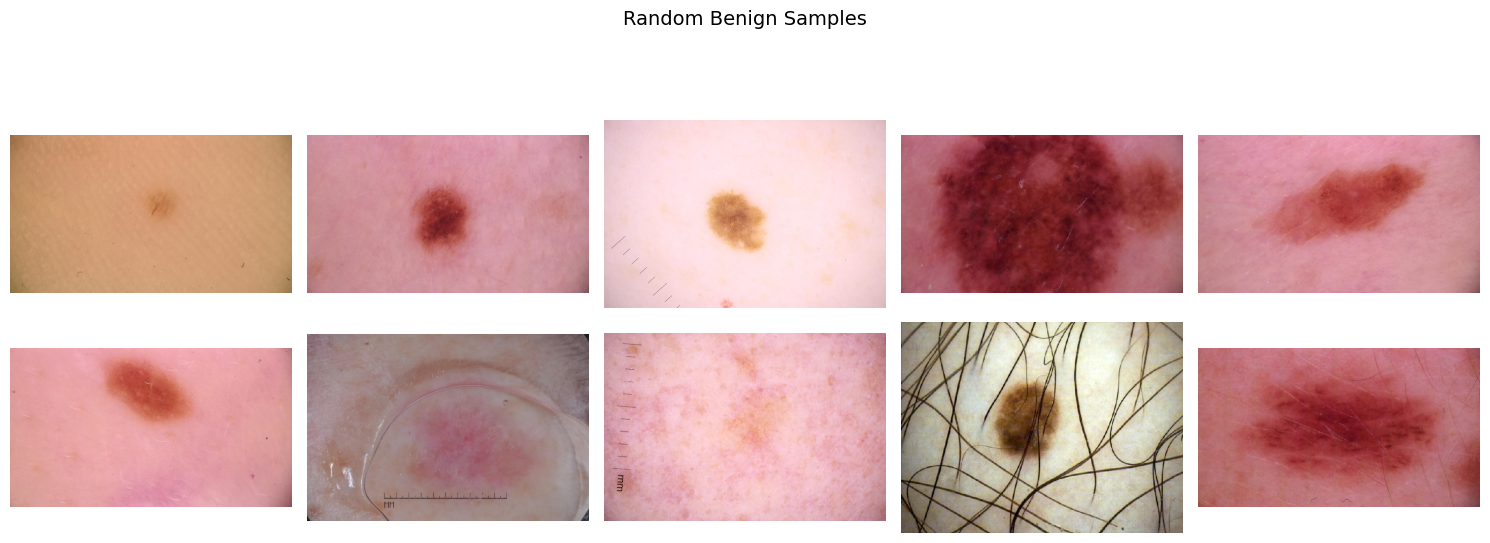

In [ ]:
random_benign_samples = train_df[train_df["target"] == 0]
show_samples(random_benign_samples, "Random Benign Samples")

The following figure shows 10 random `malignant` skin lesion samples:

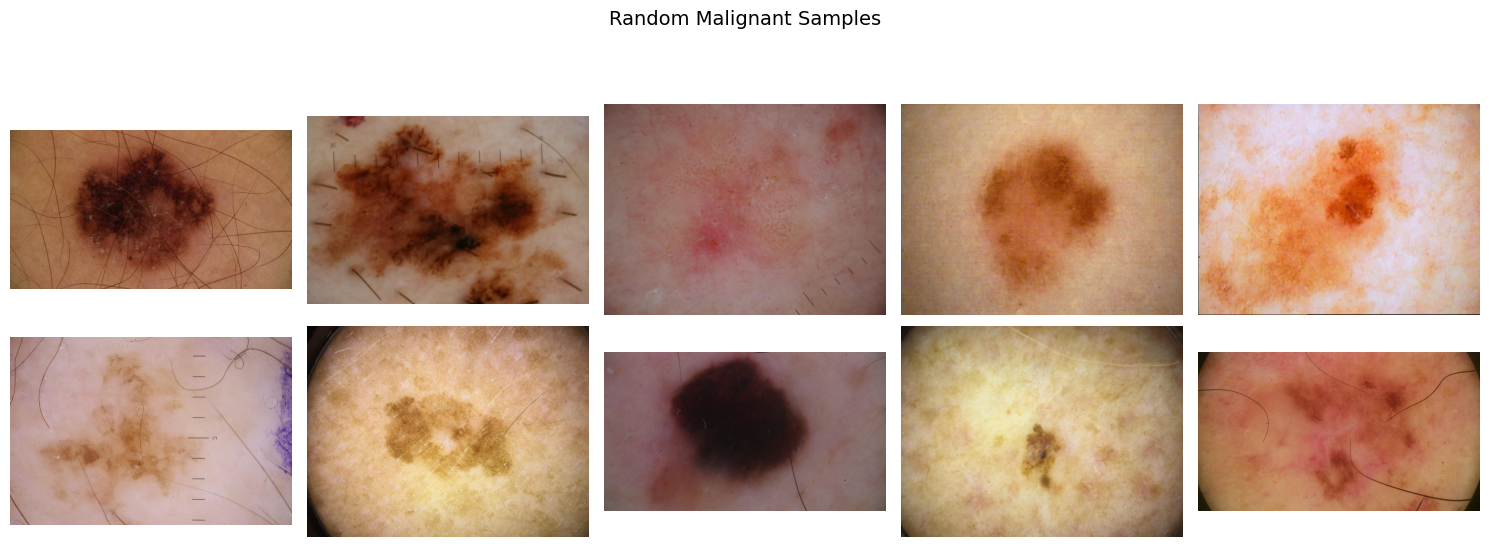

In [ ]:
random_malignant_samples = train_df[train_df["target"] == 1]
show_samples(random_malignant_samples, "Random Malignant Samples")

An initial look at the `benign` lesion samples usually shows that they are <u>more rounded and structured</u>, with relatively uniform and often lighter coloration. In contrast, `malignant` samples tend to appear more chaotic, irregular in shape, and marked by varying colors across the lesion area. These visual differences can further guide us in the manual feature extraction step.

### **Manual Feature Engineering**

One approach to feature extraction is to manually propose a feature whose value varies across the different classes. For example, if we find that `malignant` samples are typically noisier than `benign` ones, we can explicitly incorporate noise **as a feature** during training. This could help the model generalize better to unseen data. Evaluating a test sample will first require extracting the feature from the sample, and then using the enhanced model to predict the value that corresponds to the new feature vector.

**Noise Variance Feature**

The <u>Laplacian operator</u> is a filter that measures the combined rate of change of image intensity along the `x` and `y` directions. In practice, it highlights regions with rapid variations in intensity, such as edges, fine textures, or noise. To capture this information in a single scalar, <u>we define the Noise Variance feature as the variance of the Laplacian response across the entire image.</u>

In [ ]:
LAPLACIAN_APPROX = tf.constant([[0., 1., 0.],
                          [1., -4., 1.],
                          [0., 1., 0.]], tf.float32)
LAPLACIAN_APPROX = tf.reshape(LAPLACIAN_APPROX, [3, 3, 1, 1])

@tf.function
def compute_noise_batch(images):
    x = tf.image.convert_image_dtype(images, tf.float32)
    gray_images = tf.image.rgb_to_grayscale(x) if tf.shape(x)[-1] == 3 else x
    activations = tf.nn.conv2d(gray_images, LAPLACIAN_APPROX, strides=1, padding="SAME")
    _, var = tf.nn.moments(activations, axes=[1, 2, 3])
    return var

We now use the functions defined above to compute the noise feature across multiple batches (`batches=10`):

In [ ]:
def calculate_noise(dataset, batches=None):
  from tqdm.auto import tqdm

  dataset = dataset.take(batches) if batches is not None else dataset

  noise_vals = []
  label_vals = []

  for batch in tqdm(dataset, desc="Calculating Noise"):
    (images, feature_vectors), labels = batch
    noise_over_batch = compute_noise_batch(images)
    noise_vals.append(noise_over_batch.numpy())
    label_vals.append(labels.numpy())

  noise_column = np.concatenate(noise_vals, axis=0)
  label_column = np.concatenate(label_vals, axis=0)

  benign_noise = noise_column[label_column == 0]
  malignant_noise = noise_column[label_column == 1]

  return benign_noise, malignant_noise

Calculating Noise:   0%|          | 0/10 [00:00<?, ?it/s]

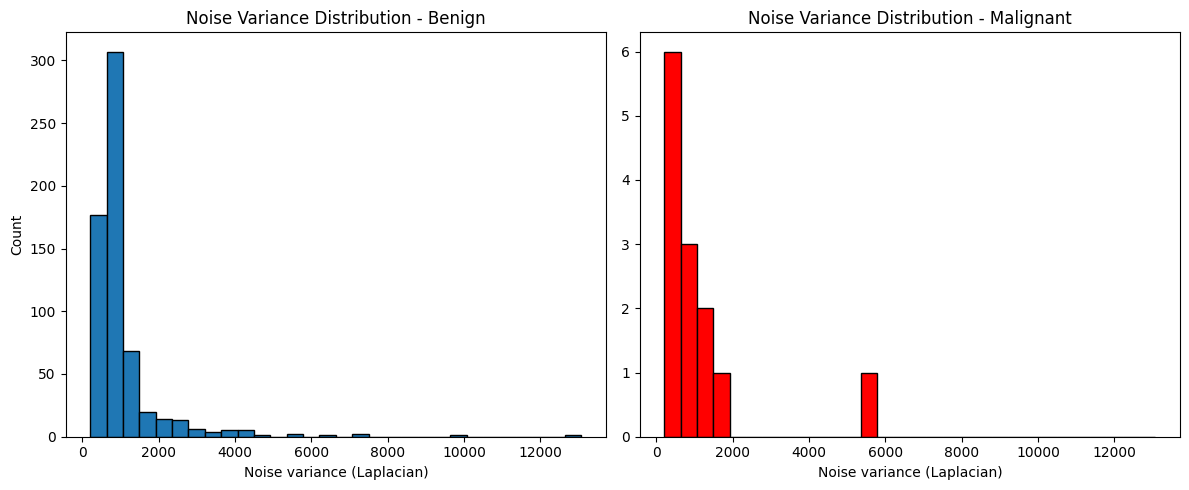

In [ ]:
benign_noise, malignant_noise = calculate_noise(train_dataset, batches=10)
all_noise_vals = np.concatenate((benign_noise, malignant_noise))
bins = np.histogram_bin_edges(all_noise_vals, bins=30)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(benign_noise, bins=bins, edgecolor="black")
axes[0].set_title("Noise Variance Distribution - Benign")
axes[0].set_xlabel("Noise variance (Laplacian)")
axes[0].set_ylabel("Count")

axes[1].hist(malignant_noise, bins=bins, edgecolor="black", color="red")
axes[1].set_title("Noise Variance Distribution - Malignant")
axes[1].set_xlabel("Noise variance (Laplacian)")

plt.tight_layout()
plt.show(block=False)

As we can see in the left histogram, `benign` lesion images tend to exhibit lower noise values, aligning with the expectation of smoother and more uniform structures. In contrast, the right histogram suggests that `malignant` cases do not consistently show high noise values, which contradicts our initial visual observation. However, since the number of `malignant` cases is relatively small compared to `benign` ones, it is difficult to draw firm conclusions based on this distribution alone.

### **Automatic Feature Extraction**

Instead of relying on hand-crafted features, we employ deep learning models to <u>automatically extract informative features</u> from the images. Using a pre-trained architecture like `EfficientNet`, the network learns feature hierarchies ranging from edges and textures to complex structures directly from the data. Next, we extract high-level feature representations using the `EfficientNetB4` model and use them to examine the underlying structure of the data:

In [ ]:
import numpy as np
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm

ReferenceVariable.IMG_SIZE = (380, 380)

def get_embeddings(model, last_layer_index, benign_batches=10, malignant_batches=None):
  model = Model(inputs=model.inputs, outputs=model.layers[last_layer_index].output)

  embeddings = []
  embedding_labels = []

  def calculate_embeddings(dataset, batches):
    for batch in tqdm(dataset.take(batches) if batches is not None else dataset, desc="Calculating Embeddings:"):
      (images, feature_vectors), labels = batch

      batch_embeddings = model(images, training=False)
      embeddings.append(batch_embeddings.numpy())
      embedding_labels.append(labels)

  calculate_embeddings(full_benign_dataset, benign_batches)
  calculate_embeddings(full_malignant_dataset, malignant_batches)

  return numpy.concatenate(embeddings, axis=0), numpy.concatenate(embedding_labels, axis=0)

In [ ]:
embeddings_file = os.path.join(project_path, "image_embedding", "all_image_embeddings.npz")

if os.path.exists(embeddings_file):
  embeddings_dict = np.load(embeddings_file)
  embeddings = embeddings_dict["embeddings"]
  embedding_labels = embeddings_dict["labels"]
else:
  base = EfficientNetB4(weights="imagenet", include_top=True, pooling="avg")
  model = Model(inputs=base.input, outputs=base.output)

  embeddings, embedding_labels = get_embeddings(base, -2, benign_batches=None)
  # Stack the batches of embeddings to a single 2D tensor.
  embeddings = numpy.vstack(embeddings)
  embedding_labels = numpy.vstack(embedding_labels)

  np.savez(file=embeddings_file, embeddings=embeddings, labels=embedding_labels)

The extracted embeddings are high-dimensional. We will utilize several dimensionality-reduction and clustering methods to check whether we can uncover meaningful patterns using these relatively simple algorithms.

**Dimensionality Reduction: PCA**

Dimensionality Reduction is a powerful technique that is often used to remove features of the feature vector that are considered less important. One common algorithm for Dimensionality Reduction is Principle Component Analysis (PCA). This algorithm projects the data onto a k-dimensional vector-space that preserves the most amount of total variance of all other vector-spaces of the same dimensionality. Here is an implementation of the algorithm:

In [ ]:
def pca_reduce(X, n_dims):
  X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
  X_centered = X_tensor - tf.reduce_mean(X_tensor, axis=0, keepdims=True)

  # TF returns S,U,V such that Xc = U diag(S) V^T
  singular_values_vector, U, V = tf.linalg.svd(X_centered, compute_uv=True, full_matrices=False)
  components = tf.transpose(V[:, :n_dims])

  Z = tf.matmul(X_centered, tf.transpose(components))
  n_minus_1 = tf.cast(tf.shape(X_centered)[0] - 1, tf.float32)
  total_var = tf.reduce_sum(singular_values_vector**2) / n_minus_1
  low_var = tf.reduce_sum((singular_values_vector[:n_dims])**2) / n_minus_1

  return {"data": Z,
          "low-dim-variance": low_var,
          "high-dim-variance": total_var,
          "principal-components": components}

Let's reduce the data to 2D and plot it on the 2D-plane using `blue` and `red` colors to differentiate between `benign` and `malignant` samples, correspondigly.

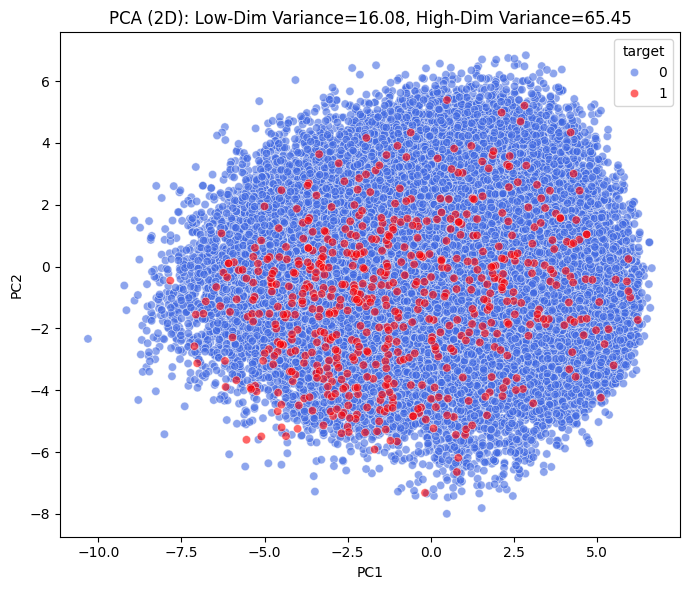

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

result = pca_reduce(embeddings, n_dims=2)
Z = result["data"].numpy()

# Build dataframe with target for coloring
df = pandas.DataFrame({
    "PC1": Z[:,0],
    "PC2": Z[:,1],
    "target": embedding_labels.flatten()
})

plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="target",
                palette={0:"royalblue", 1:"red"}, alpha=0.6)
plt.title(f"PCA (2D): Low-Dim Variance={result['low-dim-variance'].numpy():.2f}, High-Dim Variance={result['high-dim-variance'].numpy():.2f}")
plt.tight_layout()
plt.show(block=False)

It is clear that the embeddings are not linearly separable in the low-dimensional space, even when they contain highly informative features. However, it is possible that the data may still be linearly separable in its original high-dimensional space. In the next section, we will evaluate the performance of a linear classifier on the embeddings, which will also reveal whether the original high-dimensional features admit linear separability.

**Dimensionality Reduction: t-SNE**

The PCA method we used earlier reduces dimensionality by projecting the data into a linear subspace. This is effective, but its main limitation is that it can <u>only capture linear relationships</u> in the data. In contrast, t-SNE is a non-linear dimensionality reduction method. It works by <u>preserving the relative distances between points</u>, <u>learning a low-dimensional representation</u> that better reflects the local structure of the embeddings.

Below is a 2D t-SNE projection of our embeddings, where `benign` samples are shown in `blue` and `malignant` samples are shown in `red`.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 33126 samples in 0.021s...
[t-SNE] Computed neighbors for 33126 samples in 29.416s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33126
[t-SNE] Computed conditional probabilities for sample 2000 / 33126
[t-SNE] Computed conditional probabilities for sample 3000 / 33126
[t-SNE] Computed conditional probabilities for sample 4000 / 33126
[t-SNE] Computed conditional probabilities for sample 5000 / 33126
[t-SNE] Computed conditional probabilities for sample 6000 / 33126
[t-SNE] Computed conditional probabilities for sample 7000 / 33126
[t-SNE] Computed conditional probabilities for sample 8000 / 33126
[t-SNE] Computed conditional probabilities for sample 9000 / 33126
[t-SNE] Computed conditional probabilities for sample 10000 / 33126
[t-SNE] Computed conditional probabilities for sample 11000 / 33126
[t-SNE] Computed conditional probabilities for sample 12000 / 33126
[t-SNE] Computed conditional probabilities for sa

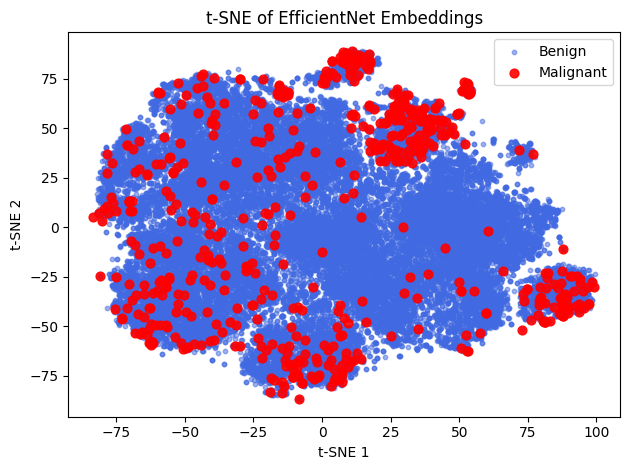

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    n_iter=1000,
    random_state=42,
    verbose=1
)
X_2d = tsne.fit_transform(embeddings)

plt.scatter(X_2d[embedding_labels.flatten()==0, 0],
            X_2d[embedding_labels.flatten()==0, 1],
            s=10, label="Benign", alpha=0.5, color="royalblue")

plt.scatter(X_2d[embedding_labels.flatten()==1, 0],
            X_2d[embedding_labels.flatten()==1, 1],
            s=40, label="Malignant", alpha=0.9, color="red")

plt.legend()
plt.title("t-SNE of EfficientNet Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

We can see from the scatter plot above that dimensionality reduction of the embeddings with the t-SNE algorithm produces a manifold-like structure for both the `benign` and `malignant` samples. Certain regions appear dominated by `benign` cases, but overall the low-dimensional representation is still <u>far from linearly separable.</u> This suggests that the data likely requires either more complex non-linear decision boundaries or the original high-dimensional feature space to achieve good separation.

## **Clustering**

Clustering is a technique used to group the data into sets of similar samples. Using it helps us understand the similarity and dissimilarity between the training samples. Here, we use **K-Means** to cluster the data into `10` groups and **k-NN** for outlier detection. Finally, we use **UMAP** to visualize the clusters in a low-dimensional space:

Embeddings shape: (33126, 1792)
k-NN outlier scoring: 19.39 sec
K-Means: 2.91 sec
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, random_state=42, verbose=True)
Sat Oct 18 14:42:53 2025 Construct fuzzy simplicial set


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sat Oct 18 14:42:53 2025 Finding Nearest Neighbors
Sat Oct 18 14:42:53 2025 Building RP forest with 14 trees
Sat Oct 18 14:42:56 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Sat Oct 18 14:43:04 2025 Finished Nearest Neighbor Search
Sat Oct 18 14:43:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Oct 18 14:43:28 2025 Finished embedding
UMAP: 36.13 sec


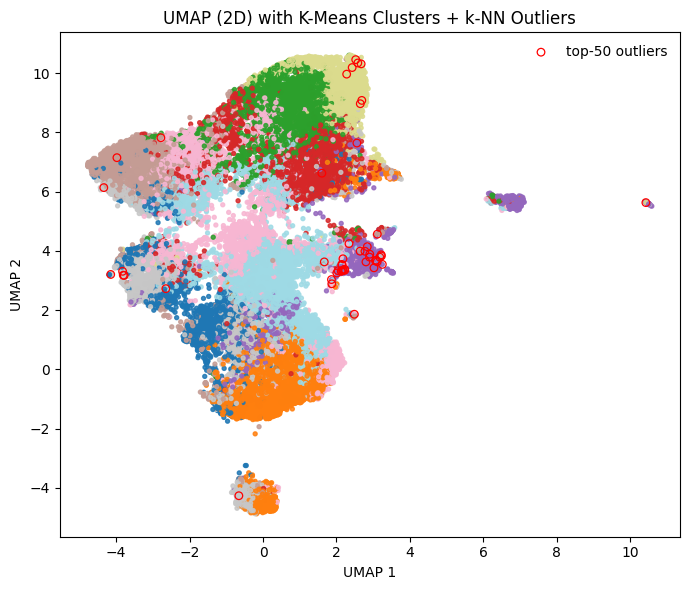

In [ ]:
import numpy as np, time
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

X = np.asarray(embeddings, dtype=np.float32)
n, d = X.shape
print("Embeddings shape:", X.shape)

t0 = time.time()
k_out = 10
nn = NearestNeighbors(n_neighbors=k_out+1, metric="euclidean").fit(X)
distances, _ = nn.kneighbors(X)
scores = distances[:, 1:].mean(axis=1)
ord_idx = np.argsort(scores)
top_outliers = ord_idx[-50:][::-1] if n >= 50 else ord_idx[::-1]
print("k-NN outlier scoring:", round(time.time() - t0, 2), "sec")

t1 = time.time()
k_clusters = 10  # set as you prefer
km = KMeans(n_clusters=k_clusters, n_init='auto', random_state=42)
labels = km.fit_predict(X)
print("K-Means:", round(time.time() - t1, 2), "sec")

try:
    import umap
except ImportError as e:
    raise ImportError("UMAP is not installed. Run: pip install umap-learn") from e

t2 = time.time()
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05, metric="cosine", random_state=42, verbose=True)
X_2d = reducer.fit_transform(X)
print("UMAP:", round(time.time() - t2, 2), "sec")

plt.figure(figsize=(7, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=8, alpha=0.85, cmap="tab20")
plt.scatter(X_2d[top_outliers, 0], X_2d[top_outliers, 1], s=30, facecolors='none', edgecolors='red', linewidths=0.9, label="top-50 outliers")
plt.title("UMAP (2D) with K-Means Clusters + k-NN Outliers")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

It's hard to draw any clear conclusions from this visualization. In higher dimensions, the separation might look different and possibly clearer. Let's check whether the outliers can be seen visually:

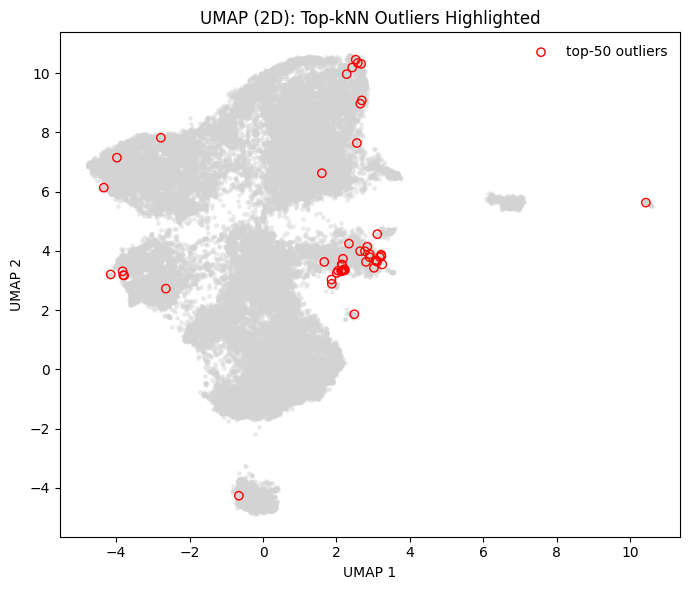

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.35, c="lightgray")
plt.scatter(X_2d[top_outliers, 0], X_2d[top_outliers, 1],
            s=36, facecolors="none", edgecolors="red", linewidths=1.0, label="top-50 outliers")
plt.title("UMAP (2D): Top-kNN Outliers Highlighted")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Even in this plot, it's difficult to make any clear conclusions about the outliers. The noisy samples appear near the edges of the low-dimensional manifold, but in the original high-dimensional space they could still lie within the data distribution, making them harder to detect. As a reminder, there are two classes we want to classify the data into. Let's see if there is any meaningful distribution of the two classes that we can observe:

Embeddings shape: (33126, 1792)
K-Means: 1.09 sec | sizes: {0: 17231, 1: 15895}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.05, n_jobs=1, random_state=42, verbose=True)
Sat Oct 18 14:58:11 2025 Construct fuzzy simplicial set


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sat Oct 18 14:58:11 2025 Finding Nearest Neighbors
Sat Oct 18 14:58:11 2025 Building RP forest with 14 trees
Sat Oct 18 14:58:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Sat Oct 18 14:58:23 2025 Finished Nearest Neighbor Search
Sat Oct 18 14:58:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Oct 18 14:58:46 2025 Finished embedding
UMAP: 35.91 sec


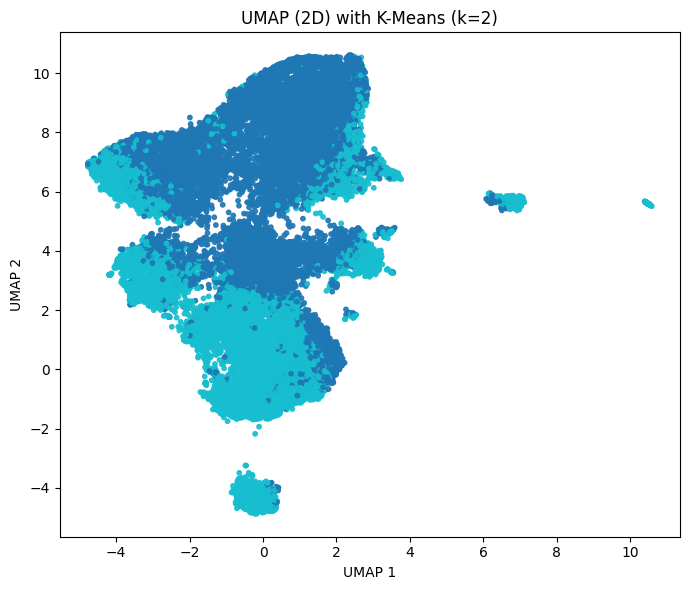

In [ ]:
import numpy as np, time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --- Load embeddings (assumes `embeddings` exists) ---
X = np.asarray(embeddings, dtype=np.float32)
n, d = X.shape
print("Embeddings shape:", X.shape)

# --- K-Means (2 clusters) ---
t1 = time.time()
k_clusters = 2
km = KMeans(n_clusters=k_clusters, n_init='auto', random_state=42)
labels = km.fit_predict(X)
print("K-Means:", round(time.time() - t1, 2), "sec",
      "| sizes:", {c: int((labels==c).sum()) for c in range(k_clusters)})

# --- UMAP 2D ---
try:
    import umap
except ImportError as e:
    raise ImportError("UMAP is not installed. Run: pip install umap-learn") from e

t2 = time.time()
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05,
                    metric="cosine", random_state=42, verbose=True)
X_2d = reducer.fit_transform(X)
print("UMAP:", round(time.time() - t2, 2), "sec")

# --- Plot ---
plt.figure(figsize=(7, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10, alpha=0.9, cmap="tab10")
plt.title("UMAP (2D) with K-Means (k=2)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


The figure above shows the separation of the data into two clusters - hopefully one will contain mostly `benign` samples and the other will contain mostly `malignant` samples. Now let's look at the class of the samples inside each cluster:

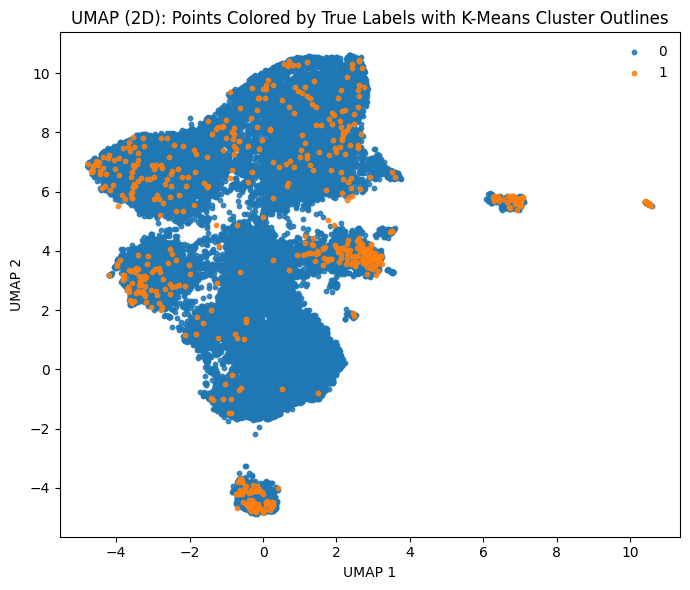

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Assumes you already have: X_2d (UMAP 2D), labels (K-Means k=2), embedding_labels (benign/malignant or 0/1)

X2 = np.asarray(X_2d)
clust = np.asarray(labels)
true_labels = np.asarray(embedding_labels).flatten() # Flatten the labels here

# Build a color map for the ground-truth labels (works for strings or 0/1)
classes = np.unique(true_labels)
cmap = plt.get_cmap("tab10")
class_to_color = {cls: cmap(i % 10) for i, cls in enumerate(classes)}

plt.figure(figsize=(7, 6))

# 1) Scatter ALL points colored by TRUE LABELS
for cls in classes:
    m = (true_labels == cls)
    if np.any(m):
        plt.scatter(
            X2[m, 0], X2[m, 1],
            s=10, alpha=0.85, color=class_to_color[cls],
            label=str(cls), zorder=2
        )

plt.title("UMAP (2D): Points Colored by True Labels with K-Means Cluster Outlines")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

The two visualizations together don't clearly show a separation between the classes - we can see `malignant` samples near `benign` ones in both clusters. However, this might be due to the low-dimensional projection, and in the original high-dimensional space the clusters could separate the data more effectively.

# **Supervised Learning**

In the previous section we mainly analyzed the distribtion of the features in the training set. We now proceed to our main task - which is to predict whether a given sample is `benign` or `malignant` using Supervised Learning methods.

### **Machine Learning Algorithm: Logistic Regression on Image Embeddings**

Earlier, projecting the data to 2D with non-linear methods like t-SNE did not yield linear separability. A natural next step is to test separability in the original high-dimensional space. First, we override the earlier `get_embeddings` function, which previously returned a visualization-only subset of embeddings:

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm

ReferenceVariable.IMG_SIZE = (380, 380)

def build_partial_model(model, last_layer_index):
  return Model(inputs=model.inputs, outputs=model.layers[last_layer_index].output)

def get_embeddings(dataset):
  model = build_partial_model(EfficientNetB4(weights="imagenet", include_top=True, pooling="avg"), -2)
  embeddings = []
  embedding_labels = []

  for batch in tqdm(dataset, desc="Calculating Embeddings:"):
    (images, feature_vectors), labels = batch

    batch_embeddings = model(images, training=False)
    embeddings.append(batch_embeddings.numpy())
    embedding_labels.append(labels)

  return numpy.concatenate(embeddings, axis=0), numpy.concatenate(embedding_labels, axis=0)

We must also reconstruct the datasets, as the `EfficientNetB4` model used in this step requires input images of size `(380 × 380)`:

In [ ]:
ReferenceVariable.IMG_SIZE = (380, 380)

train_dataset = build_dataset(train_df)
val_dataset = build_dataset(val_df)
test_dataset = build_dataset(test_df)

In [ ]:
def embeddings_exists():
  return os.path.exists(os.path.join(project_path, "image_embedding"))

if embeddings_exists():
  train_dict = np.load(os.path.join(project_path, "image_embedding", "train_embeddings.npz"))
  val_dict = np.load(os.path.join(project_path, "image_embedding", "val_embeddings.npz"))
  test_dict = np.load(os.path.join(project_path, "image_embedding", "test_embeddings.npz"))

  X_train_embeddings, y_train_embedding_labels = train_dict["X"], train_dict["y"]
  X_val_embeddings, y_val_embedding_labels = val_dict["X"], val_dict["y"]
  X_test_embeddings, y_test_embedding_labels = test_dict["X"], test_dict["y"]

else:
  X_train_embeddings, y_train_embedding_labels = get_embeddings(train_dataset)
  X_val_embeddings, y_val_embedding_labels = get_embeddings(val_dataset)
  X_test_embeddings, y_test_embedding_labels = get_embeddings(test_dataset)

We'll also cache the embeddings for later use:

In [ ]:
if not embeddings_exists():
  save_dir = os.path.join(project_path, "image_embedding")
  os.makedirs(save_dir)

  np.savez_compressed(f"{save_dir}/train_embeddings.npz",
                      X=X_train_embeddings, y=y_train_embedding_labels)

  np.savez_compressed(f"{save_dir}/val_embeddings.npz",
                      X=X_val_embeddings, y=y_val_embedding_labels)

  np.savez_compressed(f"{save_dir}/test_embeddings.npz",
                      X=X_test_embeddings, y=y_test_embedding_labels)

Now let's train a Logistic Regression classifier directly on the image embeddings and evaluate whether a linear decision boundary can separate the classes:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, confusion_matrix,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

log_reg.fit(X_train_embeddings, y_train_embedding_labels)

y_proba = log_reg.predict_proba(X_test_embeddings)[:, 1]
y_pred = log_reg.predict(X_test_embeddings)

In [ ]:
acc = accuracy_score(y_test_embedding_labels, y_pred)
error_rate = 1.0 - acc
cm = confusion_matrix(y_test_embedding_labels, y_pred)
tn, fp, fn, tp = cm.ravel()
TNR = tn / (tn + fp + 1e-12)   # TNR
TPR = tp / (tp + fn + 1e-12)   # TPR

print(f"Accuracy: {acc:.4f} Error rate: {error_rate:.4f}")
print(f"True-Positive Rate: {TPR:.4f} True-Negative Rate: {TNR:.4f}")

Accuracy: 0.9322 Error rate: 0.0678
True-Positive Rate: 0.4545 True-Negative Rate: 0.9408


The model already performs well, achieving a high accuracy of `0.9322`. However, a **True-Positive Rate** of `0.4545` indicates that the model is still having a hard time detecting `malignant` cases - suggesting that the limited number of samples affects its ability to detect them. In contrast, the **True-Negative Rate** of `0.9408` shows that the model is effective at correctly classifying `benign` cases.

Let's examine the confusion matrix to confirm this behavior:

In [ ]:
print("Confusion matrix [[tn, fp], [fn, tp]]:")
print(cm)

Confusion matrix [[tn, fp], [fn, tp]]:
[[4592  289]
 [  48   40]]


Out of all predictions, the model correctly identified `4592` `benign` cases and `40` `malignant` cases. However, it misclassified `289` `benign` cases as `malignant` (false positives) and `48` `malignant` cases as `benign` (false negatives).

To further evaluate the model, we can look at the **ROC curve**. It's built by <u>iterating over all meaningful decision boundary probabilities</u> `p=0,...,1`. For each decision boundary, we classify a sample as `positive` if its predicted probability is above `p`, and `negative` otherwise. Then, for that threshold, we calculate the corresponding `(TPR, FPR)` point. Doing this for all thresholds gives us a set of points that form the ROC curve.

For our test samples, this produces the following scatter plot that forms a curve:

ROC-AUC: 0.8407


NameError: name 'plt' is not defined

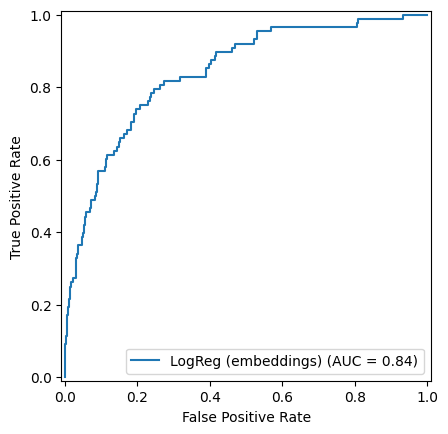

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_embedding_labels, y_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC: {roc_auc:.4f}")

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name="LogReg (embeddings)").plot()
plt.show()

The ROC-AUC represents the area under the ROC curve. Our model achieved a score of `0.8407`, which means that across all possible decision thresholds, it consistently maintains a relatively high True-Positive Rate. In other words, regardless of where we place the decision boundary, the model is overall reliable at detecting `malignant` cases when they are truly `malignant`.

### **Deep Learning Algorithm: Transfer Learning & Augmentation**

Even though we could have stopped here - since a simple Logistic Regression model on top of `EfficientNetB4` embeddings already gives us relatively good performance - we'll continue exploring ways to push the results even further using more advanced techniques.

The first approach we'll use is **Transfer Learning**, but this time in a more direct way. Earlier, we implicitly applied transfer learning by training only a Logistic Regression layer on top of the frozen `EfficientNetB4` features, which is <u>equivalent to training just the final layer of a neural network</u> (with all `EfficientNetB4` layers (without the last one) acting as a fixed feature extractor and a single sigmoid output neuron on top).

Now, we'll expand on that idea by introducing **Data Augmentation** - which is likely to have the biggest impact. Augmentation will allow us to artificially generate new training samples, helping us not only compensate for the limited number of `malignant` images, but also make the model more robust to variations in the data.

Assuming that slight transformations like rotation, contrast changes, zooming, and flipping do not alter the sample labels, we'll start by defining the augmentation layer for our model:

In [ ]:
import keras.layers as layers
import keras.activations as activations
from tensorflow.keras.applications import EfficientNetB4
from tensorflow import keras
from tensorflow.keras.models import load_model


def build_augmentation_model():
  augmentation_model = keras.Sequential([
      layers.RandomRotation(0.2, fill_mode="constant"),
      layers.RandomZoom(0.1),
      layers.RandomContrast(0.1),
      layers.RandomFlip("horizontal"),
  ])
  return augmentation_model

Let's use it now to build the final model. We will also use `SeparableConv2D` layers which are considered much more efficient than regular convolutional layers and perform as good as they are:

In [ ]:
ReferenceVariable.IMG_SIZE = (380, 380)
INPUT_CHANNELS = 3

train_dataset = build_dataset(train_df)
val_dataset = build_dataset(val_df)
test_dataset = build_dataset(test_df)

inputs = keras.Input(shape=ReferenceVariable.IMG_SIZE + (INPUT_CHANNELS, ))
augmentation_symbolic_tensor = build_augmentation_model()(inputs)
preprocessing_symbolic_tensor = preprocess_input(augmentation_symbolic_tensor)

base = EfficientNetB4(include_top=False, weights="imagenet")
base.trainable=False

base_symbolic_tensor = base(preprocessing_symbolic_tensor, training=False)

x = layers.SeparableConv2D(512, kernel_size=3, padding="same", use_bias=False)(base_symbolic_tensor)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)

x = layers.SeparableConv2D(256, kernel_size=3, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)

x = layers.GlobalAveragePooling2D()(x)
before_last_layer = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(before_last_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
metrics = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.FalseNegatives(name="fn"),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

Since this model uses only the images (without the feature vectors), we'll create new datasets accordingly:

In [ ]:
def use_images_only(sample, label):
    img, _ = sample
    return img, label

image_train_dataset = train_dataset.map(use_images_only, num_parallel_calls=tf.data.AUTOTUNE)
image_val_dataset = val_dataset.map(use_images_only, num_parallel_calls=tf.data.AUTOTUNE)
image_test_dataset = test_dataset.map(use_images_only, num_parallel_calls=tf.data.AUTOTUNE)

We'll use a callback to save the best model based on validation performance at each epoch:

In [ ]:
import time
from tensorflow.keras.callbacks import Callback

model_path = os.path.join(project_path, "model")
history_path = os.path.join(project_path, "history")

save_best_model_checkpoint = lambda filepath: keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min"
)

First, let's train the model for `10` epochs without weight balancing. Obviously, we expect bad results - but let's verify that this is the case:

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

os.makedirs(model_path, exist_ok=True)
os.makedirs(history_path, exist_ok=True)


def train_model(model, model_num, train_dataset, **kwargs):
  history_file_path = os.path.join(history_path, f"history_model_{model_num}.json")
  model_file_path = os.path.join(model_path, f"best_model_{model_num}.keras")

  history = model.fit(
      train_dataset,
      callbacks=[save_best_model_checkpoint(model_file_path)],
      **kwargs
  )

  with open(history_file_path, "w") as f:
    json.dump(history.history, f)

  return history

def plot_loss_and_rates(history_filepath, tpr, tnr):
    from json import load

    with open(history_filepath, "r") as f:
        history = load(f)

    train_loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(train_loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, train_loss, label="Training Loss")
    axes[0].plot(epochs, val_loss, label="Validation Loss")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].bar(["TPR", "TNR"], [tpr, tnr])
    axes[1].set_ylim(0, 1)
    axes[1].set_title("True Positive Rate vs True Negative Rate")

    plt.tight_layout()
    plt.show()

def evaluate_model(model, image_dataset):
  y_true = []
  y_pred = []

  for batch_image, batch_label in image_dataset:
    predictions = model.predict(batch_image)
    class_predictions = (predictions > 0.5).astype(int)
    y_true.extend(batch_label.numpy())
    y_pred.extend(class_predictions.flatten())

  y_true = numpy.array(y_true)
  y_pred = numpy.array(y_pred)

  cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
  return cm.ravel()

In [ ]:
def train_image_model(model_num, **kwargs):
  return train_model(model, model_num, image_train_dataset, validation_data=image_val_dataset, **kwargs)

In [ ]:
MODEL_NUM = 1
# history = train_image_model(MODEL_NUM, epochs=10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

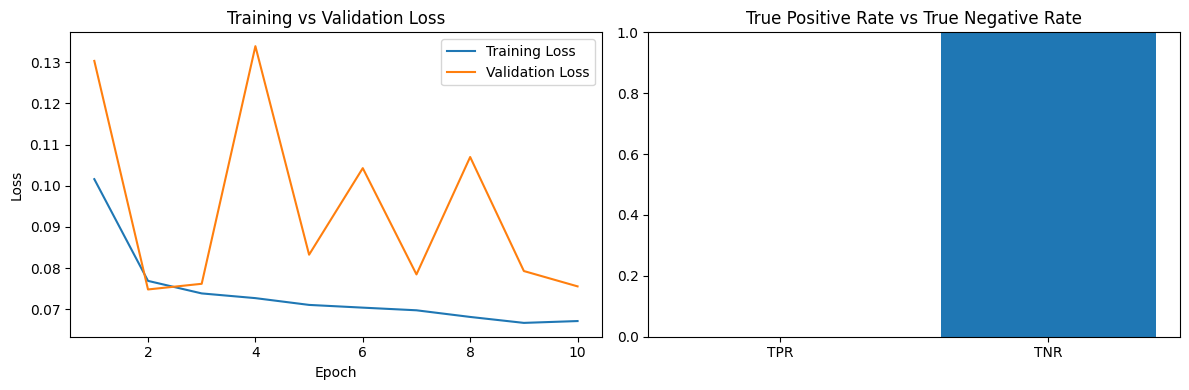

In [ ]:
from tensorflow.keras.models import load_model

MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), image_val_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4876  FP: 6  FN: 87  TP: 0


The confusion matrix shows that while the model correctly classified almost all negative samples (`4876` TN vs. `6` FP), it failed to detect any `positive` cases, producing `87` **False-Negatives** and `0` **True-Positives**. This indicates <u>a complete inability to identify the `positive` class, likely due to class imbalance</u> - **making the model ineffective despite its high accuracy** on `negatives`.

Let's build a class-balanced model and evaluate its performance on the validation set.

**Balance the Classes**

To address class imbalance in the target variable, we use Scikit-learn's built-in `compute_class_weight` function to calculate weights that ensure each class contributes proportionally to the model's learning process:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def get_balancing_weights(df, column):
  vals = df[column].values
  weights = compute_class_weight(
      class_weight="balanced",
      classes=numpy.unique(vals),
      y=vals
  )
  return dict(enumerate(weights))

class_to_weight_mapping = get_balancing_weights(train_df, "target")

Now let's use the balancing weights to train a new model:

In [ ]:
MODEL_NUM = 2
# history = train_image_model(MODEL_NUM, epochs=10, class_weight=class_to_weight_mapping)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

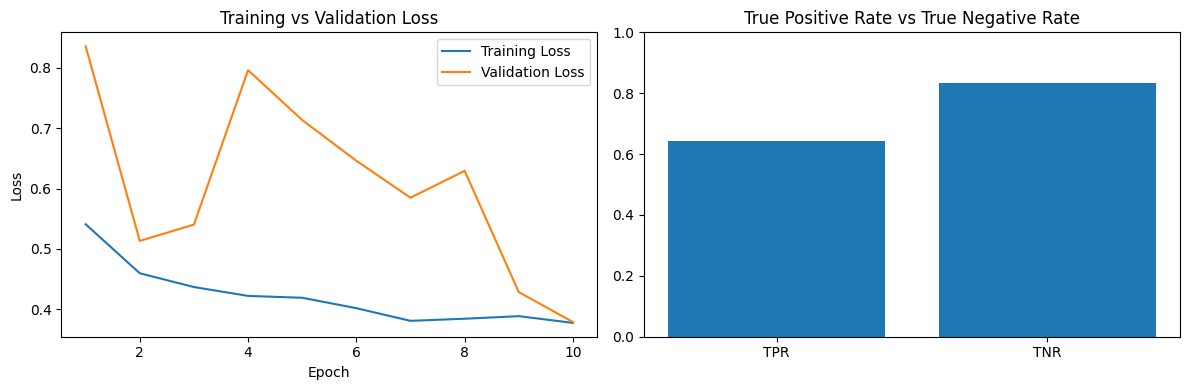

In [ ]:
MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), image_val_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4068  FP: 814  FN: 31  TP: 56


This result is both surprising and expected. The new model performs significantly better - its **True-Positive Rate** jumped from `0` to over `0.6`. However, this improvement comes with a trade-off: it now predicts `814` `negative` samples as `positive`, compared to only `6` in the previous model. Additionaly, its validation loss is around `0.4`, which is much higher than the `0.08` validation loss of the previous model.

We want to analyze the `+30%` of `malignant` validation samples that the model predicted as `benign`. However, directly examining the images themselves and extracting meaningful insights would be difficult. Instead, we'll do this later when we build a model that incorporates the metadata.

### **Deep Learning Algorithm: Transfer Learning, Augmentation and Regularization with Metadata**

Finally, let's work with the metadata we loaded earlier during preprocessing and build a multimodal model to try and reduce the validation error. As a reminder, we encoded the labels we didn't want to have any ordinal relationship. Now these features are part of our dataset's feature vector:

In [ ]:
columns_set = set(train_df.columns) - {"image_path", "image_name", "patient_id", "benign_malignant", "target", "diagnosis"}
columns_set

{'age_approx',
 'anatom_site_general_challenge_head/neck',
 'anatom_site_general_challenge_lower extremity',
 'anatom_site_general_challenge_oral/genital',
 'anatom_site_general_challenge_palms/soles',
 'anatom_site_general_challenge_torso',
 'anatom_site_general_challenge_upper extremity',
 'sex_female',
 'sex_male',
 'sex_unknown'}

So the feature vector of each sample in the dataset is made up of the following features, in the same order:

In [ ]:
sorted(columns_set)

['age_approx',
 'anatom_site_general_challenge_head/neck',
 'anatom_site_general_challenge_lower extremity',
 'anatom_site_general_challenge_oral/genital',
 'anatom_site_general_challenge_palms/soles',
 'anatom_site_general_challenge_torso',
 'anatom_site_general_challenge_upper extremity',
 'sex_female',
 'sex_male',
 'sex_unknown']

Using the `10` metadata features, we build a Fully-Connected subnetwork to process them and extract meaningful representations. The final prediction will be made by a combined model. To improve generalization and prevent overfitting, this subnetwork includes multiple dense layers with dropout between them:

In [ ]:
feature_vector_input = keras.Input(shape=(10,))

x = layers.Dense(500, activation="relu")(feature_vector_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(400, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(300, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)

A model that uses metadata features must somehow connect the Fully-Connected subnetwork to the image model we built earlier. We avoid combining the subnetworks in earlier layers because the two inputs are completely different (images and feature vectors). Instead, we connect the Fully-Connected subnetwork to the output of the last layer of the image model:

In [ ]:
combine_layer = layers.Concatenate()([before_last_layer, x])
outputs = layers.Dense(1, activation="sigmoid")(combine_layer)
multimodal_model = keras.Model(inputs=[inputs, feature_vector_input], outputs=outputs)

Let's train and evaluate the model:

In [ ]:
metrics = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.FalseNegatives(name="fn"),
]

multimodal_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
MODEL_NUM = 3
# history = train_model(multimodal_model, MODEL_NUM, train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_to_weight_mapping)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

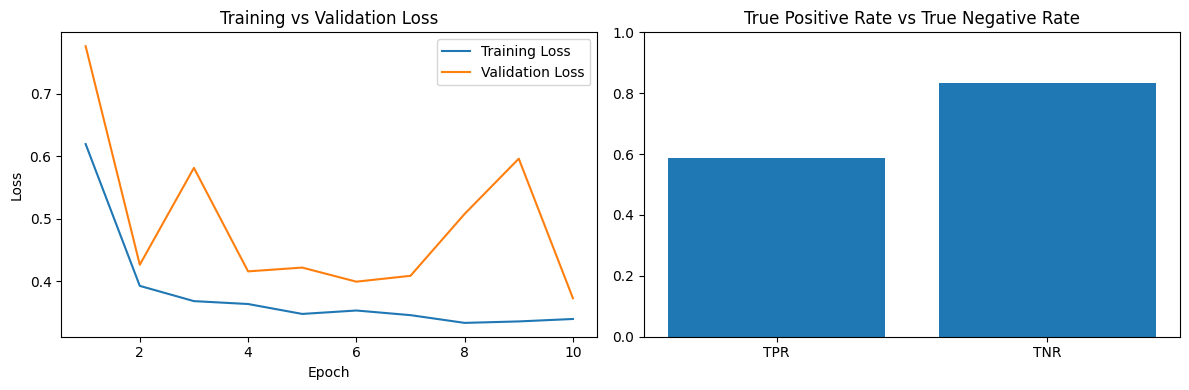

In [ ]:
MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), val_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4068  FP: 814  FN: 36  TP: 51


Even though it may seem that the following model performs slightly worse than the previous one - achieving a **True-Positive Rate** of `0.586` and a **True-Negative Rate** of `0.833` - it is noticeable from the graph above that the validation and training loss <u>remain relatively close throughout the training process</u>. This could indicate that a more robust model can be achieved with additional training.

Let's train the model for another `10` epochs and see the results:

In [ ]:
MODEL_NUM = 4
multimodal_model = load_model(os.path.join(model_path, "best_model_3.keras"))
# history = train_model(multimodal_model, MODEL_NUM, train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_to_weight_mapping)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

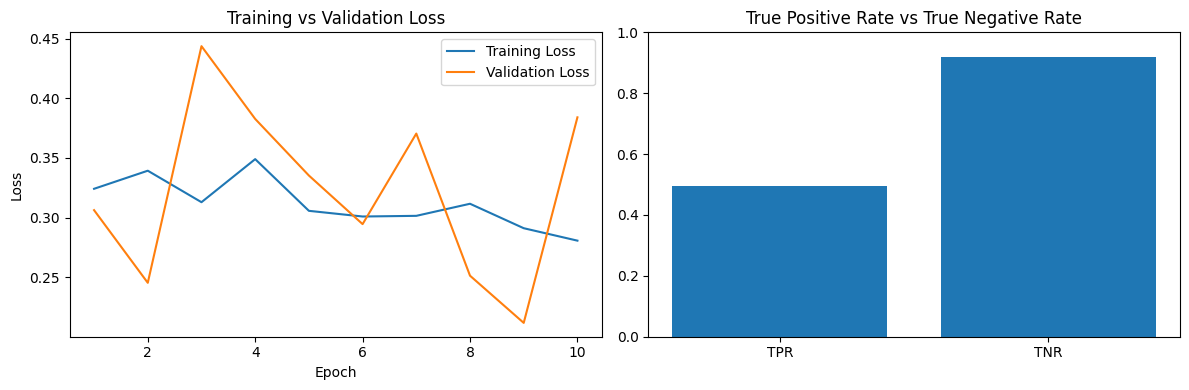

In [ ]:
MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), val_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4482  FP: 400  FN: 44  TP: 43


Sadly, even though the further-trained model's validation loss is below `0.25` - much lower than the previous model's `0.4`, and even though the **True-Negative Rate** increased to `0.918`, the **True-Positive Rate** dropped well below `0.6`.

Now let's analyze the more than `40%` of `malignant` samples that were incorrectly classified as `benign`. We'll start by converting the model's predictions into a pandas `DataFrame`:

In [ ]:
def create_prediction_df(model, dataset):
  y_true = []
  y_pred = []
  images = []
  feature_vectors = []

  for batch in dataset:
    batch_data, batch_labels = batch
    predictions = model.predict(batch_data)
    class_predictions = (predictions > 0.5).astype(int)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(class_predictions.flatten())
    batch_images, batch_feature_vectors = batch_data
    images.extend(batch_images.numpy())
    feature_vectors.extend(batch_feature_vectors.numpy())


  df = pandas.DataFrame({
      "y_true": y_true,
      "y_pred": y_pred,
      "image": images
  })

  features = ['age_approx',
    'anatom_site_general_challenge_head/neck',
    'anatom_site_general_challenge_lower extremity',
    'anatom_site_general_challenge_oral/genital',
    'anatom_site_general_challenge_palms/soles',
    'anatom_site_general_challenge_torso',
    'anatom_site_general_challenge_upper extremity',
    'sex_female',
    'sex_male',
    'sex_unknown'
  ]

  feature_vectors = numpy.array(feature_vectors)

  for feature in features:
    df[feature] = feature_vectors[:, features.index(feature)]

  return df

def decode_one_hot(df, columns, new_col_name):
    df[new_col_name] = df[columns].idxmax(axis=1).str.replace(f"{new_col_name}_", "")
    for column in columns:
      df = df.drop(column, axis=1)
    return df


Now let's analyze the **False-Negative** samples:

In [ ]:
model = load_model(os.path.join(model_path, f"best_model_4.keras"))
model_df = create_prediction_df(model, val_dataset)

sex_columns = ["sex_female", "sex_male", "sex_unknown"]
site_columns = [
    'anatom_site_general_challenge_head/neck',
    'anatom_site_general_challenge_lower extremity',
    'anatom_site_general_challenge_oral/genital',
    'anatom_site_general_challenge_palms/soles',
    'anatom_site_general_challenge_torso',
    'anatom_site_general_challenge_upper extremity'
]

decoded_model_df = decode_one_hot(model_df.copy(), sex_columns, "sex")
decoded_model_df = decode_one_hot(decoded_model_df.copy(), site_columns, "anatom_site_general_challenge")

false_negatives_df = decoded_model_df[(decoded_model_df["y_true"] == 1) & (decoded_model_df["y_pred"] == 0)]

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

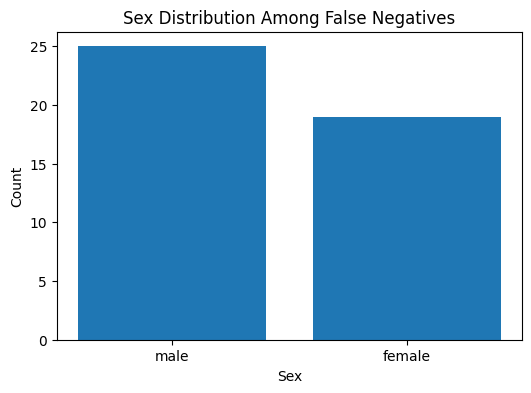

In [ ]:
import matplotlib.pyplot as plt

sex_counts = false_negatives_df["sex"].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sex_counts.index, sex_counts.values)
plt.title("Sex Distribution Among False Negatives")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

The bar plot above suggests that the **False-Positive** population is not meaningfully separated by `sex`. Let's see whether this group exhibits any notable `age`-related characteristics:

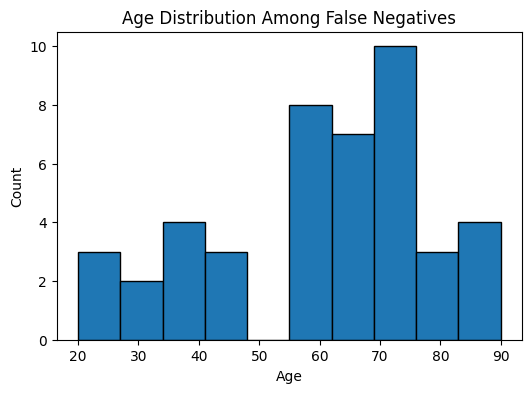

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(false_negatives_df["age_approx"], bins=10, edgecolor="black")
plt.title("Age Distribution Among False Negatives")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In the `malignant` samples, those that were misclassified as `benign` were predominantly from older `age` groups, with a notable concentration in the `55-75` range. Earlier, we observed that older individuals are much more represented in the `malignant` population overall. One possible reason for these misclassifications is that the model had to learn to distinguish `benign` from `malignant` cases across all `age` groups, and it <u>may not have had sufficient training time to properly learn</u> the separation within the larger, older-`age` population.

Therefore, we will continue training the model for `10` additional epochs and add weight regularization, which should help reduce overfitting.

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import regularizers, Model
from tensorflow.keras.layers import Dense, Input

def add_regularization(model, regularizer):
  for layer in model.layers:
      if isinstance(layer, Dense):
          layer.kernel_regularizer = regularizer

  # Keras needs model re-serialization after modifying configs
  model_json = model.to_json()
  new_model = tf.keras.models.model_from_json(model_json)
  new_model.set_weights(model.get_weights())
  return new_model

In [ ]:
MODEL_NUM = 5
multimodal_model = load_model(os.path.join(model_path, "best_model_4.keras"))

regularizer = regularizers.l2(0.001)
multimodal_model = add_regularization(multimodal_model, regularizer)

In [ ]:
metrics = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.FalseNegatives(name="fn"),
]

multimodal_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
# history = train_model(multimodal_model, MODEL_NUM, train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_to_weight_mapping)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 294s 735ms/step - accuracy: 0.8281 - auc: 0.8970 - fn: 36.6264 - fp: 2040.6208 - loss: 0.8828 - precision: 0.0799 - recall: 0.8196 - tn: 9433.2725 - tp: 169.0632 - val_accuracy: 0.7653 - val_auc: 0.8417 - val_fn: 24.0000 - val_fp: 1142.0000 - val_loss: 0.5497 - val_precision: 0.0523 - val_recall: 0.7241 - val_tn: 3740.0000 - val_tp: 63.0000
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 184s 507ms/step - accuracy: 0.8149 - auc: 0.9202 - fn: 31.7885 - fp: 2173.5027 - loss: 0.3828 - precision: 0.0768 - recall: 0.8519 - tn: 9300.3896 - tp: 173.9011 - val_accuracy: 0.8998 - val_auc: 0.8598 - val_fn: 44.0000 - val_fp: 454.0000 - val_loss: 0.2429 - val_precision: 0.0865 - val_recall: 0.4943 - val_tn: 4428.0000 - val_tp: 43.0000
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 184s 506ms/step - accuracy: 0.8134 - auc: 0.9127 - fn: 29.2006 - fp: 2163.7830 - loss: 0.3833 - precision: 0.0756 - recall: 0.8480 - tn: 9310.1104 - tp: 176.4890 - val_accuracy: 0.7118 - val_auc:

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

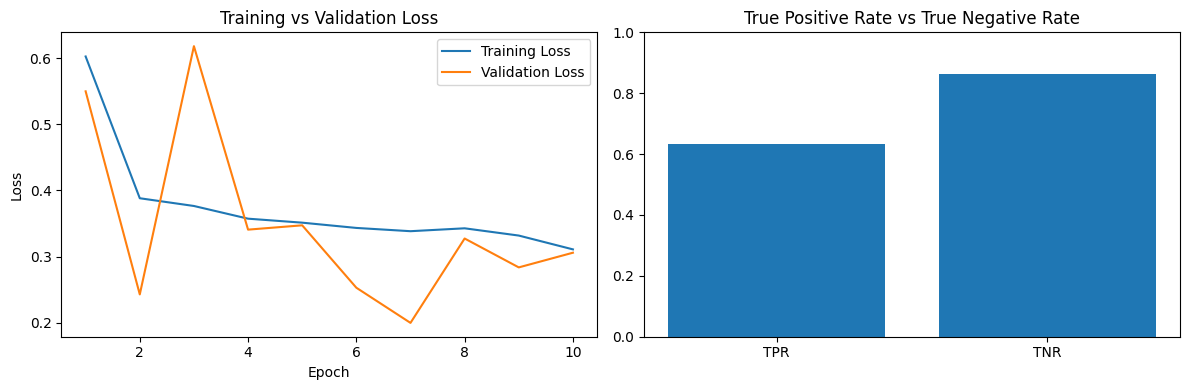

In [ ]:
MODEL_NUM = 5
MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), val_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4211  FP: 671  FN: 32  TP: 55


Wow - the model improved substantially. The **True-Negative Rate** stayed above `0.80`, but the most notable gain was in the **True-Positive Rate**, which rose from `0.494` to `0.63`. Regularization plus the additional training appear to have helped, but we'll stop here to avoid further training costs.

Finally, we evaluate the model on the **test set**:

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

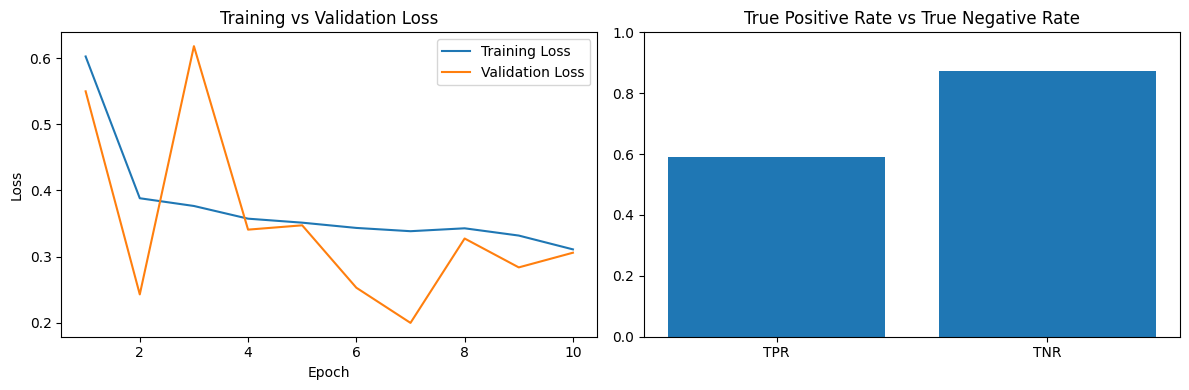

In [ ]:
MODEL_NUM = 5
MODEL_PATH = os.path.join(model_path, f"best_model_{MODEL_NUM}.keras")
MODEL_HISTORY_PATH = os.path.join(history_path, f"history_model_{MODEL_NUM}.json")

tn, fp, fn, tp = evaluate_model(load_model(MODEL_PATH), test_dataset)
plot_loss_and_rates(MODEL_HISTORY_PATH, tp / (tp + fn), tn / (tn + fp))

In [ ]:
print(f"TN: {tn}  FP: {fp}  FN: {fn}  TP: {tp}")

TN: 4265  FP: 616  FN: 36  TP: 52


Compared to the validation set (TN: 4211, FP: 671, FN: 32, TP: 55), the numbers are very close. The true negatives increased slightly from `4211` to `4265`, and false positives decreased from `671` to `616`. The true positives dropped slightly from `55` to `52`, and false negatives rose from `32` to `36`. Overall, the proportions are consistent, indicating that the model generalizes well and did not overfit to the validation data.